In [1]:
#Install cpu only version of torchvision, for accessing MNIST dataset
#GPU version may have compatibility issues with JAX
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu  

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".98"
import jax.numpy as jnp
from jax.nn import log_softmax,one_hot
from jax import grad,vmap
import jax
import time


In [3]:
import torchvision
def get_dataset_torch():
    mnist = {
        'train': torchvision.datasets.MNIST('./data', train=True, download=True),
        'test': torchvision.datasets.MNIST('./data', train=False, download=True)
    }

    ds = {}

    for split in ['train', 'test']:
        ds[split] = {
            'image': mnist[split].data.numpy(),
            'label': mnist[split].targets.numpy()
        }

        # cast from np to jnp and rescale the pixel values from [0,255] to [0,1]
        ds[split]['image'] = jnp.float32(ds[split]['image']) / 255.0
        ds[split]['label'] = jnp.int16(ds[split]['label'])

        # torchvision returns shape (B, 28, 28).
        # hence, append the trailing channel dimension.
        ds[split]['image'] = jnp.expand_dims(ds[split]['image'], 3)

    return ds['train'], ds['test']

train, test = get_dataset_torch()
train['image']=train['image'].reshape([60000,28*28])
train['image']=jnp.concatenate((train['image'],jnp.ones([60000,1])),1)
train['label']=one_hot(train['label'],10)
test['image']=test['image'].reshape([10000,28*28])
test['image']=jnp.concatenate((test['image'],jnp.ones([10000,1])),1)
test['label']=one_hot(test['label'],10)

In [4]:
@jax.jit
def lpost(beta):
    return jnp.sum(jnp.square(beta))*10/2-(log_softmax(train['image']@beta.reshape(785,10))*train['label']).sum()
grad_lpost=jax.jit(grad(lpost))

import scipy.optimize
optim_res=scipy.optimize.minimize(lpost,jnp.zeros(7850),method="L-BFGS-B",jac=grad_lpost)
beta_min=optim_res.x

def hvp(x, v):
    return jax.grad(lambda x: jnp.vdot(grad_lpost(x), v))(x)
def hvp_beta_min(v):
    return hvp(beta_min, v)
vhvp_beta_min=vmap(hvp_beta_min)

from jax.lax import dynamic_update_slice
import numpy as np
ID=jnp.identity(7850)
nbeta=7850
hess_min=jnp.zeros([7850,7850])
vmap_size=25

for it in range(7850//vmap_size):
    slice1=ID[(it*vmap_size):((it+1)*vmap_size),:]
    hess1=vhvp_beta_min(slice1)
    hess_min=dynamic_update_slice(hess_min,hess1,(it*vmap_size,0))

hess_min=(hess_min+jnp.transpose(hess_min))/2
ehess_min,evhess_min=jnp.linalg.eigh(hess_min)
sqrt_D = jnp.diag(jnp.sqrt(ehess_min))
invsqrt_D = jnp.diag(jnp.pow(ehess_min,-0.5))

inv_sqrt_hess_min =  jnp.asarray(evhess_min @ invsqrt_D @ evhess_min.T)

def lpost_precond(beta_precond):
    beta=beta_precond.reshape([1,nbeta])@inv_sqrt_hess_min+beta_min.reshape([1,nbeta])
    return jnp.sum(jnp.square(beta))*10/2-(log_softmax(train['image']@beta.reshape(785,10))*train['label']).sum()
grad_lpost_precond=grad(lpost_precond)
vmap_grad_lpost_precond=vmap(grad_lpost_precond)
# def vmap_grad_lpost_precond(beta_precond):
#     return beta_precond

def prob_precond(beta_precond):
    beta=beta_precond.reshape([1,nbeta])@inv_sqrt_hess_min+beta_min.reshape([1,nbeta])
    return jnp.exp((log_softmax(test['image']@beta.reshape(785,10))*test['label']).sum(axis=1))

prob_ind=np.asarray((prob_precond(jnp.zeros(nbeta))>0.1)*(prob_precond(jnp.zeros(nbeta))<0.9))
dim_prob_ind=np.sum(prob_ind)
test_image_ind=jnp.asarray(test['image'][prob_ind,:])
test_label_ind=jnp.asarray(test['label'][prob_ind,:])

def test_function_precond(beta_precond):
    beta=(beta_precond.reshape([1,nbeta])@inv_sqrt_hess_min+beta_min.reshape([1,nbeta])).reshape([nbeta,])
    return jnp.concatenate([beta,(jnp.exp((log_softmax(test_image_ind@beta.reshape(785,10))*test_label_ind).sum(axis=1)))])

vmap_test_function_precond=vmap(test_function_precond)

# def vmap_test_function_precond(beta_precond):
#     return beta_precond

In [5]:
from methods.multilevel_ubu_approx import multilevel_ubu_approx,vmap_multilevel_ubu_approx#,multilevel_ubu,xi_h_mx,transform_xi,gen_xiarr,multiMCMC

from jax import random

nbeta=7850
M=1.0
m=1.0


def invcholHprodv(x):
    return x

def Hprodv(x):
    return x

def exp_hM(x,h):
    nbeta=x.shape[1]//2
    return jnp.concatenate([x[:,0:nbeta]*jnp.cos(h)+x[:,nbeta:(2*nbeta)]*jnp.sin(h),-x[:,0:nbeta]*jnp.sin(h)+x[:,nbeta:(2*nbeta)]*jnp.cos(h)],1)

r=2.0**(1.5)
c=1.0/16
beta_min=beta_min.reshape([1,nbeta])
maxlevel=8
max_parallel_chain=32
repfullgrad=10
test_dim=nbeta+dim_prob_ind


niter=800
burnin=40
rep=1024
max_Gaussian_samp=niter*max_parallel_chain//16

key=random.key(170424)
h=jnp.array(0.2)/jnp.sqrt(M)
gam=jnp.sqrt(m)
#_=multilevel_ubu_approx(niter,burnin,rep,h,gam, repfullgrad,vmap_grad_lpost_precond, vmap_test_function_precond, invcholHprodv,Hprodv,exp_hM,r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain,max_Gaussian_samp,0,key)

In [6]:
par_batch=16
key=random.key(345632)
par_runs=16
subkey=random.split(key,par_runs)

res=vmap_multilevel_ubu_approx(niter,burnin,rep,h,gam, repfullgrad,vmap_grad_lpost_precond, vmap_test_function_precond, invcholHprodv,Hprodv,exp_hM,r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain,max_Gaussian_samp,subkey,par_batch)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.1 h/2: 0.05
Lev: 2 / 3 xn/x2n error: VmapTracer<float32[]>
h: 0.05 h/2: 0.025
Lev: 3 / 4 xn/x2n error: VmapTracer<float32[]>
h: 0.025 h/2: 0.0125
Lev: 4 / 5 ...
hm: 0.0125
Multi error: VmapTracer<float32[3]>


In [7]:
key=random.key(34745)
par_runs=16*4
subkey=random.split(key,par_runs)

start_time=time.time()
res=vmap_multilevel_ubu_approx(niter,burnin,rep,h,gam, repfullgrad,vmap_grad_lpost_precond, vmap_test_function_precond, invcholHprodv,Hprodv,exp_hM,r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain,max_Gaussian_samp,subkey,par_batch)
end_time=time.time()
total_time=end_time-start_time
print("Total time:", total_time)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3]
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.1 h/2: 0.05
Lev: 2 / 3 xn/x2n error: VmapTracer<float32[]>
h: 0.05 h/2: 0.025
Lev: 3 / 4 xn/x2n error: VmapTracer<float32[]>
h: 0.025 h/2: 0.0125
Lev: 4 / 5 ...
hm: 0.0125
Multi error: VmapTracer<float32[3]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.1 h/2: 0.05
Lev: 2 / 3 xn/x2n error: VmapTracer<float32[]>
h: 0.05 h/2: 0.025
Lev: 3 / 4 xn/x2n error: VmapTracer<float32[]>
h: 0.025 h/2: 0.0125
Lev: 4 / 5 ...
hm: 0.0125
Multi error: VmapTracer<float32[3]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.1 h/2: 0.

In [13]:
from methods.process_res_multi import process_res_multi
ess,grad_per_ess=process_res_multi(res,jnp.arange(par_runs))
print("max grad per ess coordinates:",jnp.max(grad_per_ess[:nbeta]))
print("min ess coordinates:",jnp.min(ess[:nbeta]))
print("ess/sec for UBUBU approx coordinates:",jnp.min(ess[:nbeta])/(total_time/par_runs))

print("max grad per ess prediction:",jnp.max(grad_per_ess[nbeta:]))
print("min ess prediction:",jnp.min(ess[nbeta:]))
print("ess/sec for UBUBU approx prediction:",jnp.min(ess[nbeta:])/(total_time/par_runs))

mean repruns: [1.02400e+03 6.40000e+01 2.30000e+01 8.00000e+00 3.00000e+00 1.00000e+00
 2.96875e-01 2.03125e-01 4.68750e-02]
test_mean_var: 1.2171034e-07
ngradtot: 53118.344
test_mean_lev_0_comp1: -4.0084367e-05
max_test_mean_lev_0_var: 1.2396944e-07
test_squaremean_lev_0_comp1: 0.09995162
blockstart: [   0 1024 1088 1111 1119 1122 1123 1124 1125]
blockend: [1024 1088 1111 1119 1122 1123 1124 1125 1126]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: 0.19237547
max_lev_test_mean_diff_var: 4.78926e-07 repruns[lev+1,0]: 64
lev: 2
max_lev_test_mean_diff: 0.000469979
max_lev_test_mean_diff_var: 1.9775057e-09 repruns[lev+1,0]: 23
lev: 3
max_lev_test_mean_diff: 0.00023637313
max_lev_test_mean_diff_var: 9.966842e-10 repruns[lev+1,0]: 8
lev: 4
max_lev_test_mean_diff: 0.00011436883
max_lev_test_mean_diff_var: 6.3085986e-10 repruns[lev+1,0]: 3
lev: 5
max_mean_diff_lev: 0.00011909753
max_test_mean_var: 2.2925464e-09
test_post_var: 0.09999942
median test mean var: 1.3661761e-07
median test post var: 0.

In [ ]:
from methods.bootstrap_res import bootstrap_res
bootstrap_samp=64
key=random.key(23847)
keys=random.split(key,bootstrap_samp)

grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2=bootstrap_res(res,bootstrap_samp,par_runs,nbeta,process_res_multi,keys)
import pickle
with open("./output/MNIST_UBUBU_approx_precond.pkl", "wb") as file:
    pickle.dump((ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2),file)
    
print("Bootstrap sd for max grad per ess coordinates:", sdmax)
print("Bootstrap sd for max grad per ess prediction:", sdmax2)

mean repruns: [1.02400e+03 6.40000e+01 2.30000e+01 8.00000e+00 3.00000e+00 1.00000e+00
 2.34375e-01 1.40625e-01 9.37500e-02]
test_mean_var: 1.2164278e-07
ngradtot: 53118.344
test_mean_lev_0_comp1: -7.692838e-05
max_test_mean_lev_0_var: 1.2530896e-07
test_squaremean_lev_0_comp1: 0.09995221
blockstart: [   0 1024 1088 1111 1119 1122 1123 1124 1125]
blockend: [1024 1088 1111 1119 1122 1123 1124 1125 1126]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: 0.19242328
max_lev_test_mean_diff_var: 4.9488904e-07 repruns[lev+1,0]: 64
lev: 2
max_lev_test_mean_diff: 0.0004725722
max_lev_test_mean_diff_var: 1.989589e-09 repruns[lev+1,0]: 23
lev: 3
max_lev_test_mean_diff: 0.00023540574
max_lev_test_mean_diff_var: 1.0029056e-09 repruns[lev+1,0]: 8
lev: 4
max_lev_test_mean_diff: 0.00011488576
max_lev_test_mean_diff_var: 6.0854183e-10 repruns[lev+1,0]: 3
lev: 5
max_mean_diff_lev: 0.00012613833
max_test_mean_var: 2.6542635e-09
test_post_var: 0.10004345
median test mean var: 1.3661882e-07
median test post var: 

In [1]:
import pickle
with open("./output/MNIST_UBUBU_approx_precond.pkl", "rb") as file:
    (ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2)=pickle.load(file)
    
print("Bootstrap sd for max grad per ess coordinates:", sdmax)
print("Bootstrap sd for max grad per ess prediction:", sdmax2)

Bootstrap sd for max grad per ess coordinates: 0.002670267
Bootstrap sd for max grad per ess prediction: 0.012029919


<Figure size 640x480 with 0 Axes>

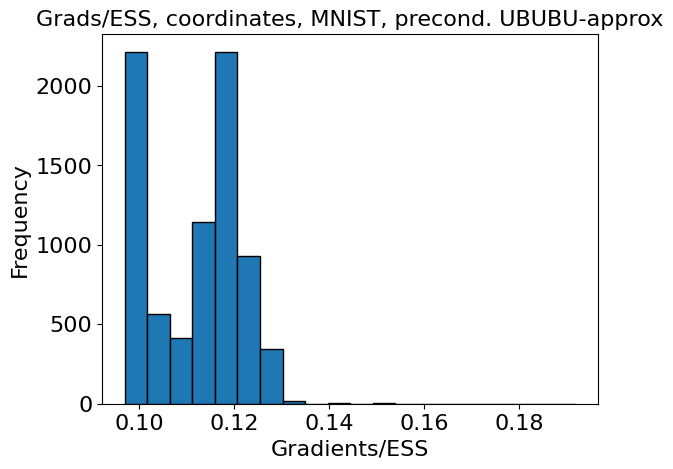

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, coordinates, MNIST, precond. UBUBU-approx",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
nbeta=7850
plt.hist(grad_per_ess[0:nbeta],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_approx_MNIST_coordinates.pdf", format="pdf", bbox_inches='tight') 
plt.show()

<Figure size 640x480 with 0 Axes>

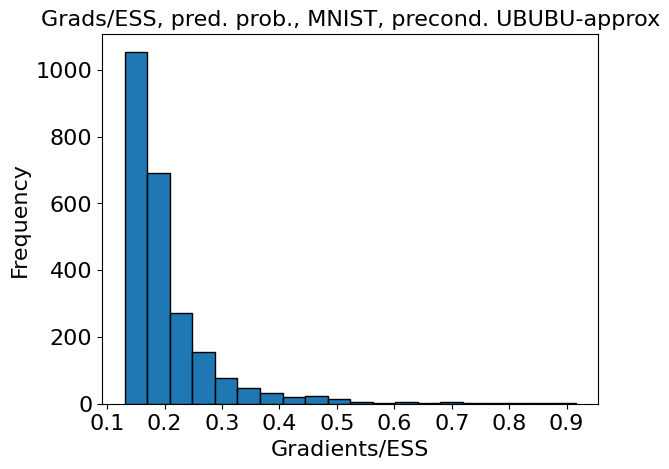

In [9]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, pred. prob., MNIST, precond. UBUBU-approx",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[nbeta:],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_approx_MNIST_prediction_prob.pdf", format="pdf", bbox_inches='tight') 
plt.show()